In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

data_path = "features_3_sec.csv"
data = pd.read_csv(data_path)
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from google.colab import drive
# drive.mount('/content/drive/MyDrive/')

In [3]:
# Extract features and labels
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode the labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.15, random_state=42)


# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)




X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [4]:
class GTZANDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

train_dataset = GTZANDataset(X_train, y_train)
val_dataset = GTZANDataset(X_val, y_val)
test_dataset= GTZANDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
train_dataset.features.shape

torch.Size([6793, 58])

In [6]:
print(train_loader)

In [7]:
class CNNModel(nn.Module):
    def __init__(self, input_size=58, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * (input_size // 4), 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (batch_size, 1, input_size)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):
    def __init__(self, input_size=58, d_model=128, nhead=8, num_layers=2, num_classes=10):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.position_encoding = self.position_encoding_init(d_model)
        self.transformer_layer = TransformerEncoderLayer(d_model, nhead)
        self.transformer = TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def position_encoding_init(self, d_model):
        position = torch.arange(0, 1).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pos_enc = torch.zeros(1, 1, d_model)
        pos_enc[0, :, 0::2] = torch.sin(position * div_term)
        pos_enc[0, :, 1::2] = torch.cos(position * div_term)
        return pos_enc

    def forward(self, x):
        x = x.unsqueeze(0)  # Add sequence length dimension (1, batch_size, input_size)
        x = self.embedding(x)
        x = x + self.position_encoding
        x = self.transformer(x)
        x = x.squeeze(0)  # Remove sequence length dimension (batch_size, d_model)
        x = self.fc(x)
        return x


In [10]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,model_filename):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        epoch_loss = train_loss / len(train_dataset)
        epoch_acc = train_corrects.double() / len(train_dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        model.eval()
        val_loss = 0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = val_corrects.double() / len(val_dataset)
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")

        torch.save(model.state_dict(), model_filename)
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def plot_history(train_loss, train_acc, val_loss, val_acc):
    plt.figure()
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


Epoch 1/50, Loss: 1.3947, Accuracy: 0.5073, Validation Loss: 1.0480, Validation Accuracy: 0.6547
Epoch 2/50, Loss: 0.9580, Accuracy: 0.6672, Validation Loss: 0.8935, Validation Accuracy: 0.7064
Epoch 3/50, Loss: 0.7960, Accuracy: 0.7246, Validation Loss: 0.7990, Validation Accuracy: 0.7373
Epoch 4/50, Loss: 0.6688, Accuracy: 0.7684, Validation Loss: 0.7490, Validation Accuracy: 0.7556
Epoch 5/50, Loss: 0.5642, Accuracy: 0.8016, Validation Loss: 0.6904, Validation Accuracy: 0.7731
Epoch 6/50, Loss: 0.4864, Accuracy: 0.8357, Validation Loss: 0.6577, Validation Accuracy: 0.7898
Epoch 7/50, Loss: 0.4329, Accuracy: 0.8493, Validation Loss: 0.5904, Validation Accuracy: 0.8048
Epoch 8/50, Loss: 0.3619, Accuracy: 0.8762, Validation Loss: 0.6372, Validation Accuracy: 0.8073
Epoch 9/50, Loss: 0.3009, Accuracy: 0.8965, Validation Loss: 0.5701, Validation Accuracy: 0.8148
Epoch 10/50, Loss: 0.2517, Accuracy: 0.9143, Validation Loss: 0.5548, Validation Accuracy: 0.8290
Epoch 11/50, Loss: 0.2064, Ac

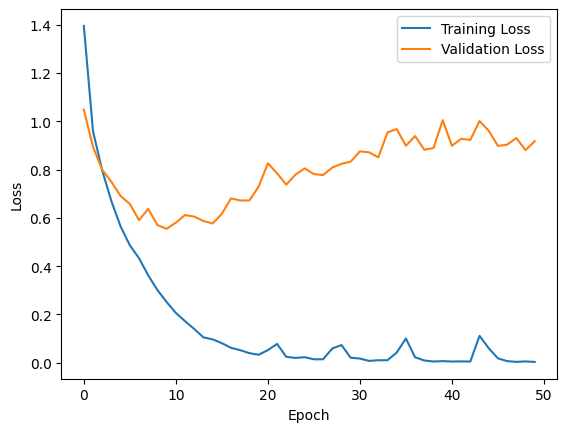

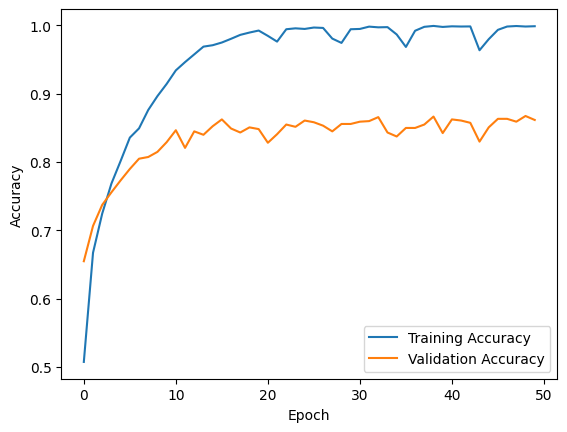

In [11]:
# Choose the model: CNNModel() or TransformerModel()
model = CNNModel()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,"cnn_model.pth")
plot_history(train_loss, train_acc, val_loss, val_acc)


Epoch 1/50, Loss: 1.1431, Accuracy: 0.5924, Validation Loss: 0.9168, Validation Accuracy: 0.6772
Epoch 2/50, Loss: 0.8010, Accuracy: 0.7199, Validation Loss: 0.7404, Validation Accuracy: 0.7556
Epoch 3/50, Loss: 0.6383, Accuracy: 0.7774, Validation Loss: 0.6410, Validation Accuracy: 0.7848
Epoch 4/50, Loss: 0.5213, Accuracy: 0.8192, Validation Loss: 0.5517, Validation Accuracy: 0.8182
Epoch 5/50, Loss: 0.4432, Accuracy: 0.8441, Validation Loss: 0.5361, Validation Accuracy: 0.8399
Epoch 6/50, Loss: 0.3493, Accuracy: 0.8788, Validation Loss: 0.5806, Validation Accuracy: 0.8257
Epoch 7/50, Loss: 0.3006, Accuracy: 0.8996, Validation Loss: 0.5297, Validation Accuracy: 0.8365
Epoch 8/50, Loss: 0.2820, Accuracy: 0.9028, Validation Loss: 0.4987, Validation Accuracy: 0.8407
Epoch 9/50, Loss: 0.2023, Accuracy: 0.9311, Validation Loss: 0.5177, Validation Accuracy: 0.8565
Epoch 10/50, Loss: 0.1987, Accuracy: 0.9338, Validation Loss: 0.4337, Validation Accuracy: 0.8699
Epoch 11/50, Loss: 0.1814, Ac

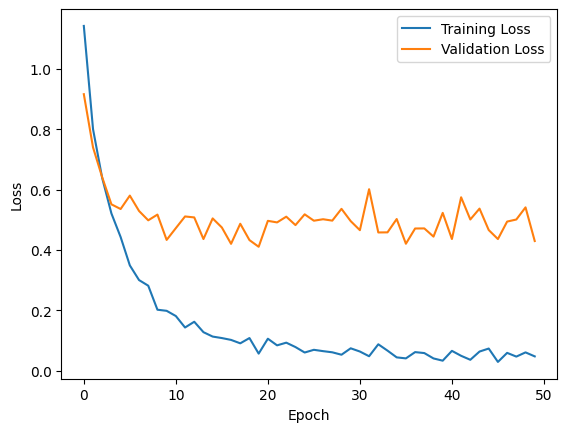

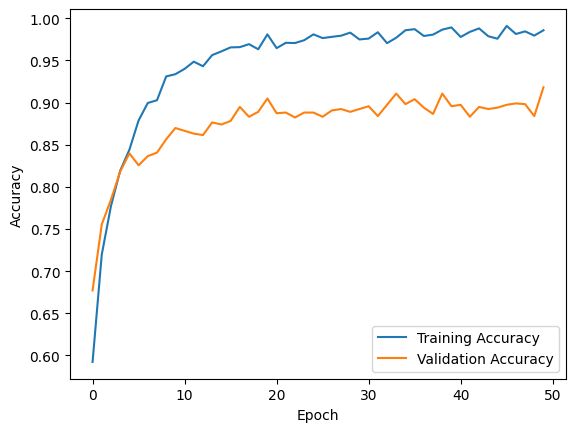

In [12]:
# Choose the model: CNNModel() or TransformerModel()
# model = CNNModel()
model = TransformerModel()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, "transformer_model.pth")
plot_history(train_loss, train_acc, val_loss, val_acc)

In [14]:
cnn_model = CNNModel()  # or OptimizedCNNModel()
cnn_model.load_state_dict(torch.load("cnn_model.pth"))

transformer_model = TransformerModel()
transformer_model.load_state_dict(torch.load("transformer_model.pth"))


def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(len(X_test)):
            input_tensor = X_test[i].clone().detach().unsqueeze(0)
            target_tensor = y_test[i].clone().detach().long().unsqueeze(0)

            output = model(input_tensor)
            _, predicted = torch.max(output.data, 1)
            total += target_tensor.size(0)
            correct += (predicted == target_tensor).sum().item()
    return correct / total

cnn_test_accuracy = evaluate_model(cnn_model, X_test, y_test)
transformer_test_accuracy = evaluate_model(transformer_model, X_test, y_test)

print(f"Test Accuracy of CNNModel: {cnn_test_accuracy * 100:.2f}%")
print(f"Test Accuracy of TransformerModel: {transformer_test_accuracy * 100:.2f}%")


Test Accuracy of CNNModel: 87.19%
Test Accuracy of TransformerModel: 92.04%


In [15]:
cnn_model = CNNModel()  # or OptimizedCNNModel()
cnn_model.load_state_dict(torch.load("cnn_model.pth"))

transformer_model = TransformerModel()
transformer_model.load_state_dict(torch.load("transformer_model.pth"))

data_path = "features_30_sec.csv"
data = pd.read_csv(data_path)


# Extract features and labels
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode the labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=22)


X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

test_dataset= GTZANDataset(X_test, y_test)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(len(X_test)):
            input_tensor = X_test[i].clone().detach().unsqueeze(0)
            target_tensor = y_test[i].clone().detach().long().unsqueeze(0)
            output = model(input_tensor)
            _, predicted = torch.max(output.data, 1)
            total += target_tensor.size(0)
            correct += (predicted == target_tensor).sum().item()
    return correct / total

cnn_test_accuracy = evaluate_model(cnn_model, X_test, y_test)
transformer_test_accuracy = evaluate_model(transformer_model, X_test, y_test)

print(f"Test Accuracy of CNNModel: {cnn_test_accuracy * 100:.2f}%")
print(f"Test Accuracy of TransformerModel: {transformer_test_accuracy * 100:.2f}%")

Test Accuracy of CNNModel: 98.20%
Test Accuracy of TransformerModel: 99.20%
